In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

#4pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#Load dataset
ds = pd.read_csv('STMECH_AUS_SS_V1.txt', delimiter='\t')


In [3]:
#Remove the columns (Zr, Ta, V, W ...) with 0 values
ds_chem_1 = ds.iloc[:, 0:7]
ds_chem_2 = ds.iloc[:, 9]
ds_chem_3 = ds.iloc[:, 11:19]
mech_prop = ds.iloc[:,30:33]
mech_prop_temp = ds.iloc[:,29]

#Create the dataset X and Y
ds_chem_raw = pd.concat([ds_chem_1, ds_chem_2, ds_chem_3, mech_prop, mech_prop_temp], axis=1)


# #Elonagation has 'Na' values, select the raws and remove from dataset
ds_chem = ds_chem_raw[ds_chem_raw['El(%)'].str.contains('Na') == False]

#Remove 473K, 573K, 673K,873K,1073K, 1023K
data_298 = ds_chem[ ds_chem['Temperature (K)'] == 298 ]
data_373 = ds_chem[ ds_chem['Temperature (K)'] == 373 ]
data_773 = ds_chem[ ds_chem['Temperature (K)'] == 773 ]
data_973 = ds_chem[ ds_chem['Temperature (K)'] == 973 ]

data_raw = pd.concat([data_298.iloc[:, 16:19], data_373.iloc[:, 16:19], data_773.iloc[:, 16:19], data_973.iloc[:, 16:19]])
labels_raw = pd.concat([data_298.iloc[:, 19], data_373.iloc[:, 19], data_773.iloc[:, 19], data_973.iloc[:, 19]])

data_raw = data_raw.astype(float)
labels_raw.replace([298, 373, 773, 973], [0,1,2,3], inplace = True)

#train-test split
X_test_raw, X_train_raw, y_test, y_train = train_test_split(data_raw, labels_raw, test_size=0.75, random_state=0, shuffle=True)

#Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.fit_transform(X_test_raw)

#Convert to 2D PyTorch tesnor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)#.reshape(-1, 1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)#.reshape(-1, 1)




In [4]:
#Create model

class class_model(nn.Module):
    def __init__(self):
        super().__init__()

        #input layer
        self.input = nn.Linear(3,32)


        # hidden layer
        self.hidden1 = nn.Linear(32,32)

        # hidden layer
        # self.hidden2 = nn.Linear(64,64)

        #output layer
        self.output = nn.Linear(32,4)

        #Softmax
        self.act_output = nn.Softmax(dim=1)

    #forwards
    def forward(self,x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden1(x))
        # x = F.relu(self.hidden2(x))
        x = self.output(x)
        x = self.act_output(x)
        return x

model = class_model()


In [5]:
#Import model
loaded_model = model
loaded_model.load_state_dict(torch.load('aus_ss.pt'))
loaded_model.eval()


class_model(
  (input): Linear(in_features=3, out_features=32, bias=True)
  (hidden1): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=4, bias=True)
  (act_output): Softmax(dim=1)
)

In [6]:
# compute the predictions

# manually compute losses
# final forward pass
predictions = loaded_model(X_test)
pred = torch.argmax(predictions, dim=1)
#pred, y_test

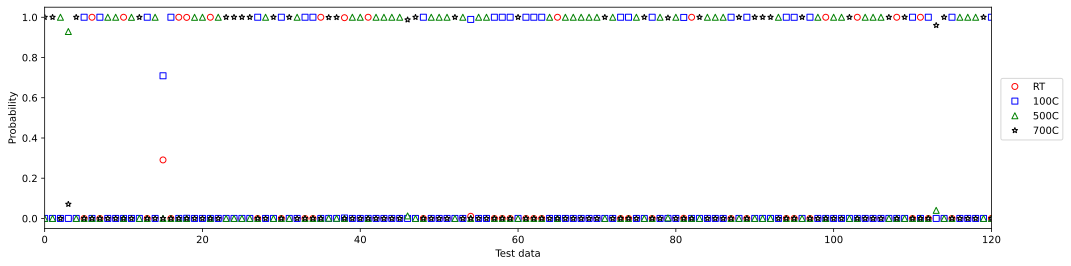

In [7]:
fig = plt.figure(figsize=(17,4))

colorshape = [  'ro','bs','g^','k*' ]
for i in range(4):
  plt.plot(predictions[:,i].detach(),colorshape[i],markerfacecolor='w')

plt.xlabel('Test data')
plt.ylabel('Probability')
plt.legend(['RT','100C','500C', '700C'],loc=(1.01,.4))
plt.xlim(0,120)
plt.show()

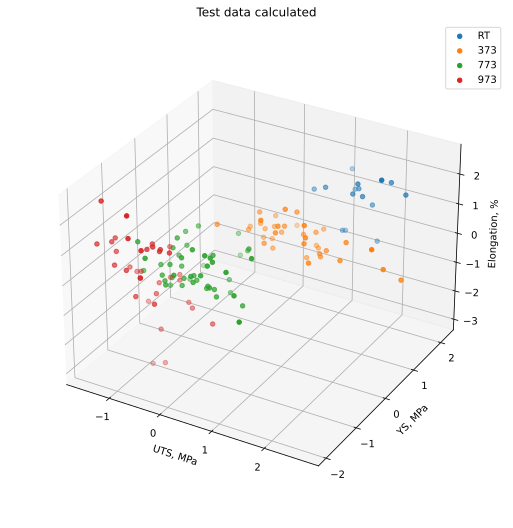

In [8]:
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')
ax.scatter(X_test[np.where(pred==0)[0],0],X_test[np.where(pred==0)[0],1],X_test[np.where(pred==0)[0],2], label='RT')
ax.scatter(X_test[np.where(pred==1)[0],0],X_test[np.where(pred==1)[0],1],X_test[np.where(pred==1)[0],2], label='373')
ax.scatter(X_test[np.where(pred==2)[0],0],X_test[np.where(pred==2)[0],1],X_test[np.where(pred==2)[0],2], label='773')
ax.scatter(X_test[np.where(pred==3)[0],0],X_test[np.where(pred==3)[0],1],X_test[np.where(pred==3)[0],2], label='973')
ax.set_xlabel('UTS, MPa')
ax.set_ylabel('YS, MPa')
ax.set_zlabel('Elongation, %')
ax.set_box_aspect(aspect=None, zoom=0.9)
ax.set_title('Test data calculated')
#ax.view_init(55,10)
ax.legend()
plt.show()




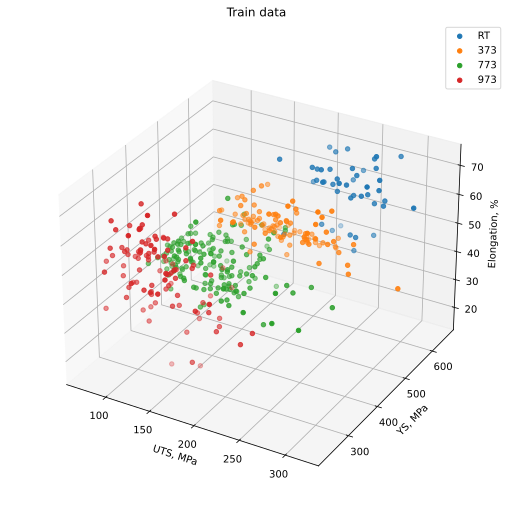

In [9]:
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')
ax.scatter(X_train_raw.iloc[np.where(y_train==0)[0],0],X_train_raw.iloc[np.where(y_train==0)[0],1],X_train_raw.iloc[np.where(y_train==0)[0],2], label='RT')
ax.scatter(X_train_raw.iloc[np.where(y_train==1)[0],0],X_train_raw.iloc[np.where(y_train==1)[0],1],X_train_raw.iloc[np.where(y_train==1)[0],2], label='373')
ax.scatter(X_train_raw.iloc[np.where(y_train==2)[0],0],X_train_raw.iloc[np.where(y_train==2)[0],1],X_train_raw.iloc[np.where(y_train==2)[0],2], label='773')
ax.scatter(X_train_raw.iloc[np.where(y_train==3)[0],0],X_train_raw.iloc[np.where(y_train==3)[0],1],X_train_raw.iloc[np.where(y_train==3)[0],2], label='973')
ax.set_xlabel('UTS, MPa')
ax.set_ylabel('YS, MPa')
ax.set_zlabel('Elongation, %')
ax.set_box_aspect(aspect=None, zoom=0.9)
ax.set_title('Train data')
#ax.view_init(55,10)
ax.legend()
plt.show()

# X_train_raw.iloc[np.where(y_train==0)[0],0]